In [2]:
from brian2 import *
import matplotlib
import random
import math
from scipy import stats
import pandas as pd
import numpy as np
import csv

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]
WARNING    'i' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 2. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


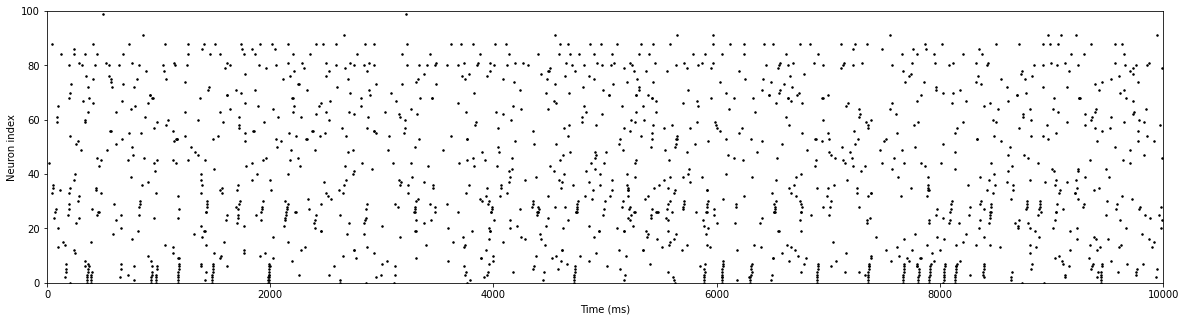

In [3]:
SPIKE = 1000
defaultclock.dt = 0.5*ms
dt = float(defaultclock.dt * 1000)
'''
This function takes in three input lists: a 2D list of neuron sequence comprised of indices, a 2D list of
sequence times, and a 1D list of delay functions that returns a delay between the neurons (all lists should be the
same length). Additionally, it uses a num_seq integer argument for the number of sequences to plant (cannot be more than
the length of seq_indices/seq_times). It then records a very strong current for the sequences (with the given order/delays)
starting with the first index for each sequence time in the current row. 
Returns a matrix that has T rows and N columns, where T and N are the number of timesteps and neuron indices, 
respectively. Each entry in the matrix represents the current strength being sent to the neuron at a given time.
'''
def create_adv_input_seqs(seq_indices, seq_times, seq_delays, num_seq):
  res = [[0]*n for _ in range(steps)]  # T x N resulting "spike" matrix
  delays = [] 
  for i in range(num_seq):
    delays.clear()
    for j in range(len(seq_indices[i]) - 1):  # Append the result of the current delay function to the delay list
      delays.append(seq_delays[i]())
    for k in range(len(seq_times[i])):  # For each time in the current list of sequence times
      curStep = int(int(seq_times[i][k]) / dt)
      for l in range(len(seq_indices[i])):  # Loop through the sequence
        res[curStep][seq_indices[i][l]] = SPIKE  # Record the corresponding spike in the result matrix 
        if (l != (len(seq_indices[i]) - 1)):
          curStep += int(delays[l] / dt)  # Increment the time step by the equivalent of delays[l] ms
  return res

'''
These delay functions are intended to specify the delay (in ms) between spikes in a sequence. Simple delays are constant numbers while
the uniform and normal delays sample from a uniform and normal distribution with avg. ~10 ms.
'''
def simpleDelay():
  return 1
def simpleMidDelay():
  return 5
def simpleLongDelay():
  return 10
def uniformDelay():
  return np.random.randint(0, 21)
def normalDelay():
  return abs(int(np.random.normal(10, 5)))

start_scope()
n = 100
seed(42069)  # I am very mature

runtime = 10000*ms
steps = int(runtime/defaultclock.dt)

# Parameters outlining how many sequences to trigger and how many times they show up throughout the runtime.
num_seq = [1]
num_instances = [20]
seq_delays = [simpleDelay, simpleDelay, uniformDelay, normalDelay, simpleDelay, simpleLongDelay, normalDelay, uniformDelay, uniformDelay, normalDelay, simpleMidDelay, uniformDelay]
for w in range(len(num_seq)):
  for x in range(len(num_instances)):
    stdTime = []
    seq_times = []
    seq_indices = [[0, 1, 2], [20, 21, 22], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [11, 12, 13, 14, 15, 16, 17, 18, 19, 20], [21, 22, 23, 24, 25, 26, 27, 28, 29, 30], [31, 32, 33, 34, 35, 36, 37, 38, 39, 40], [41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
          [51, 52, 53, 54, 55, 56, 57, 58, 59, 60], [61, 62, 63, 64, 65, 66, 67, 68, 69, 70], [71, 72, 73, 74, 75, 76, 77, 78, 79, 80], [81, 82, 83, 84, 85, 86, 87, 88, 89, 90], [91, 92, 93, 94, 95, 96, 97, 98, 99, 0]]
  # Randomize firing times
    for i in range(num_seq[w]):
      for j in range(num_instances[x]):
        stdTime.append(np.random.randint(0, runtime / ms - 500))
      seq_times.append(stdTime.copy())
      stdTime.clear()

    stimulus = TimedArray(create_adv_input_seqs(seq_indices, seq_times, seq_delays, num_seq[w]), dt=defaultclock.dt)
    path = 'data/Embedded/epng_' + str(num_seq[w]) + 's' + str(num_instances[x]) + 'i' + '.txt'

    # The model
    neuron_eqs = Equations('''
    dv/dt = (0.04*v**2+5.*v+140- u + g_exc - g_inh + noise * randn())/ms + stimulus(t, i)/ms: 1 (unless refractory)
    du/dt = a*(b*v-u)/ms                             : 1 (unless refractory)
    g_exc :1
    g_inh :1
    noise :1
    a :1
    b :1
    c :1
    d :1
    ''')

    thresh = 30
    N = NeuronGroup(n, model=neuron_eqs, threshold='v>=thresh', reset = 'v = c; u += d;  g_exc=0; g_inh=0', refractory=0.1*ms,
    method='euler')

    Ne = N[:int(0.8*n)]
    Ni = N[int(0.8*n):]

    re = np.random.random(int(0.8*n))      ; ri = np.random.random(int(0.2*n))
    Ne.noise = 5.0                 ; Ni.noise = 2.0
    Ne.a = 0.02                    ; Ni.a = 0.02 + 0.08 * ri
    Ne.b = 0.2                     ; Ni.b = 0.25 - 0.05 * ri
    Ne.c = -65.0 + 15.0 * re**2    ; Ni.c = -65.0
    Ne.d = 8.0 - 6.0 * re**2       ; Ni.d = 2.0
    Ne.v = -65.0                   ; Ni.v = -65.0
    Ne.u = Ne.v * Ne.b           ; Ni.u = Ni.v * Ni.b

    # Embedded PNG specs
    prefix = 3
    tolerance = 0
    rate = 1
    S = Synapses(Ne, N, model="w:1", on_pre='v += (thresh) / (prefix - tolerance)')

    png_list = [[0, 1, 2, 3, 4, 5, 6, 7], [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]] 
    delay = []
    # Loop through list of PNGs and make connections according to prefix
    for i in range(len(png_list)):
      for j in range(len(png_list[i])):
        cur = len(png_list[i]) - j - 1  # Connect going backwards
        pre_list = []
        if cur >= prefix:  # Each non-prefix neuron connects to prefix number of neurons before it
          for k in range(prefix): 
            prev = len(png_list[i]) - j - k - 2  
            pre_list.append(png_list[i][prev])
          if pre_list:  # If the list of presynaptic connections isn't empty, connect them to the current neuron
            S.connect(i=pre_list, j=png_list[i][cur])
          for l in range(len(pre_list)):
            delay.append((l + 1)/rate)  # Could unroll the loop
    S.delay = delay * ms  # 'clip(delay, 0*ms, inf*ms)'  # This link says it's a 1D array: https://groups.google.com/g/briansupport/c/h0ys_4tn4es?pli=1
    M = SpikeMonitor(N)
    run(runtime)

    figure(figsize=(20,5))
    plot(M.t/ms, M.i,'.', ms=3, color='black')
    xlim(0, 10000)
    ylim(0, n)
    xlabel('Time (ms)')
    ylabel('Neuron index');

    show()

    # Format data and write data frame to disk as a txt file:
    data = M.get_states(['i', 't'], units=False, format='pandas')
    data['i'] += 1
    np.savetxt(path, data.values, fmt='%d\t%f')
